# «Модель прогнозирования стоимости жилья для агентства недвижимости

##### Ваша задача — разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

1) Провести разведывательный анализ и очистку исходных данных.
2) Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3) Построить модель для прогнозирования стоимости недвижимости.
4) Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость

#### Импорт необходимых библиотек

In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


import missingno
from uszipcode import SearchEngine #библиотека поиска данных 

import re
from ydata_profiling import ProfileReport #библиотека для EDA


import category_encoders as ce # импорт для работы с кодировщиком

from sklearn import model_selection, preprocessing, linear_model, metrics,tree, ensemble
from scipy.stats import shapiro, mannwhitneyu
from haversine import haversine, Unit
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import RandomizedSearchCV
import optuna


In [96]:
df = pd.read_csv('output\df_clean.csv') 

### Подготовка данных к моделированию

In [97]:
## Проведем первичную обработку данных 

#удалим дубликаты
print('Количество дубликатов: {}'.format(df[df.duplicated()].shape[0]))
df = df.drop_duplicates()
df.shape

Количество дубликатов: 0


(365369, 25)

In [98]:
#зафиксируем для удобства наличие пропусков
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

baths_clean                27.928204
population                  0.237021
median_household_income     0.237021
housing_units               0.237021
occupied_housing_units      0.237021
dtype: float64

In [99]:
#заменим отсутствующие значения, которые по какой-то причине были пропущены при обработке


#создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
values = {
    'baths_clean': df['baths_clean'].mode()[0],
    'population': df['population'].mode()[0],
    'median_household_income': df['median_household_income'].mode()[0],
    'housing_units': df['housing_units'].mode()[0],
    'occupied_housing_units': df['occupied_housing_units'].mode()[0]
}
#заполняем оставшиеся записи константами в соответствии со словарем values
df = df.fillna(values)
#выводим результирующую долю пропусков
display(df.isnull().mean())

Unnamed: 0                 0.0
zipcode                    0.0
target_clean               0.0
log_target_clean           0.0
private_pool_join          0.0
mlsid_join_bool            0.0
sqft_clean                 0.0
log_sqft_clean             0.0
baths_clean                0.0
fireplace_booled           0.0
population                 0.0
lat                        0.0
lng                        0.0
state_zip                  0.0
median_household_income    0.0
housing_units              0.0
occupied_housing_units     0.0
major_city_ch              0.0
status_cl                  0.0
property_type_fin          0.0
home_age                   0.0
remodeled_year_bool        0.0
heating_system             0.0
mean_rating                0.0
min_dist_school            0.0
dtype: float64

In [100]:
#переименуем однообразно колонки таблицы
df.columns = ['index','zipcode', 'target', 'target_log', 'private_pool', 'mls_id', 'sqft', 'sqft_log', 'bath', 'fireplace', 'population', 'lat', 'lng', 'state',
              'median_h_income', 'h_units', 'occupied_h_units', 'zip_major_city', 'status', 'property_type', 'home_age', 'remodel_fact', 'heating_system', 'school_mean_rat', 'school_min_dist']

In [101]:
#проверим какие столбцы не являются числовыми, а значит требуют преобразования
object_columns = [col for col in df.columns
    if ((df[col].dtypes == 'object') | \
        (df[col].dtype.name == 'category') | \
        (df[col].dtypes == 'datetime64[ns]'))]

# смотрим, что попадает под преобразование
print(f'Преобразованию подлежит {len(object_columns)} столбцов с нечисловыми данными:')
object_columns

Преобразованию подлежит 5 столбцов с нечисловыми данными:


['state', 'zip_major_city', 'status', 'property_type', 'heating_system']

In [102]:
#закодируем категориальные признаки

encoder = ce.OneHotEncoder(cols=['state','zip_major_city', 'status','property_type', 'heating_system'] ) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df[['state','zip_major_city', 'status','property_type', 'heating_system']])
data = pd.concat([df, type_bin], axis=1)

In [103]:
#удалим колонки после категоризации
data = data.drop(['state','zip_major_city', 'status','property_type', 'heating_system'], axis = 1)

#а также колонку с индексом
data = data.drop(['index'], axis = 1)

print('После преобразования получилось:', (data.shape[1]-2) ,'признаков')
#2 - это 2 вида целевого признака

После преобразования получилось: 105 признаков


In [104]:
#разделим выгрузку на обучающую и тестовую
X = data.drop(['target','target_log'], axis=1)
y_log = data['target_log']
y_abs = data['target']
X_train, X_test, y_train_log, y_test_log, y_train_abs, y_test_abs = model_selection.train_test_split(X, y_log, y_abs, test_size=0.3, random_state=42)
X_train.shape[0]

255758

In [105]:
#стандартизируем признаки
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline model


Построим собственно 1ую модель, в которую заберем все признаки без исключения.
В качестве точки отсчета возьмем линейную регрессию с параметрами по умолчанию. Качество модели будем оценивать метрикой MAE и R^2 

In [106]:
#строим и обучаем модель линейной регрессии
basemodel = linear_model.LinearRegression()
basemodel.fit(X_train_scaled, y_train_log)
y_predicted_train = basemodel.predict(X_train_scaled)
y_predicted_test = basemodel.predict(X_test_scaled)

Так как целевой признак в модели взят в лог масштабе, нам необходимо его вернуть в фактические значения

In [107]:
y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

In [108]:
basemodel_mae_train = metrics.median_absolute_error(y_train_abs, y_predicted_train_abs)
basemodel_mae_test = metrics.median_absolute_error(y_test_abs, y_predicted_test_abs)

basemodel_r2_train = metrics.r2_score(y_train_log, y_predicted_train)
basemodel_r2_test = metrics.r2_score(y_test_log, y_predicted_test)

print('MAE базовой модели train: %.3f' % basemodel_mae_train)
print('MAE базовой модели test: %.3f' % basemodel_mae_test)

print('R^2 базовой модели train: %.3f' % basemodel_r2_train)
print('R^2 базовой модели test: %.3f' % basemodel_r2_test)

MAE базовой модели train: 98651.410
MAE базовой модели test: 98063.464
R^2 базовой модели train: 0.584
R^2 базовой модели test: 0.588


Итак, на базовой модели получили для тестовой выборки медиану ошибки более 98.6 тыс. $. Достаточно много. 
по метрике R2 - которая помогает понять, какую долю (дисперсии) смогла уловить модель в данных. Позволяет сравнить, насколько модель лучше, чем простое предсказание средним. Оценка также не супер, но для реальных моделей более чем неплохая

Попробуем доработать наш бейзлайн.

Для этого вернемся к тому датасету до разделения и стандартизации.

## Дополнительная обработка данных

In [109]:
df

,index,zipcode,target,target_log,private_pool,mls_id,sqft,sqft_log,bath,fireplace,...,h_units,occupied_h_units,zip_major_city,status,property_type,home_age,remodel_fact,heating_system,school_mean_rat,school_min_dist
0,0,28387,418000.0,12.943237,0,1,2900,7.972811,3.5,1,...,7608.0,6612.0,others,active,single-family,3.0,0,OTHER,5.200000,2.70
1,1,99216,310000.0,12.644328,0,1,1947,7.574558,3.0,0,...,10906.0,10144.0,others,active,single-family,3.0,0,NO DATA,4.000000,1.01
2,2,90049,2895000.0,14.878496,1,1,3000,8.006701,2.0,1,...,18097.0,16657.0,Los Angeles,active,single-family,61.0,1,AIR,6.666667,1.19
3,3,75205,2395000.0,14.688894,0,1,6457,8.773075,8.0,1,...,9985.0,9016.0,Dallas,active,single-family,16.0,1,AIR,9.000000,0.10
4,4,32908,5000.0,8.517193,0,1,0,0.000000,2.0,0,...,4230.0,3657.0,others,active,land,0.0,0,NO HEATING NEED,4.666667,3.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365364,374405,20001,799000.0,13.591116,0,1,1417,7.257003,3.0,0,...,18751.0,16500.0,Washington,active,condo,12.0,0,AIR,3.000000,0.10
365365,374406,33180,1249000.0,14.037854,1,1,4017,8.298540,6.0,0,...,20316.0,14197.0,Miami,not defined,single-family,32.0,1,OTHER,5.000000,1.10
365366,374407,60657,674999.0,13.422466,0,1,2000,7.601402,3.0,0,...,41483.0,37865.0,Chicago,active,condo,98.0,0,OTHER,4.333333,0.40
365367,374408,11434,528000.0,13.176852,0,0,1152,7.050123,3.0,0,...,21681.0,20244.0,others,active,single-family,72.0,1,OTHER,4.500000,0.48


### Обработка целевого признака target

In [110]:
print(df['target'].describe()/1000)

count       365.369000
mean        644.634158
std        1835.212745
min           0.001000
25%         189.900000
50%         324.500000
75%         585.000000
max      195000.000000
Name: target, dtype: float64


Text(0.5, 1.0, 'target_log')

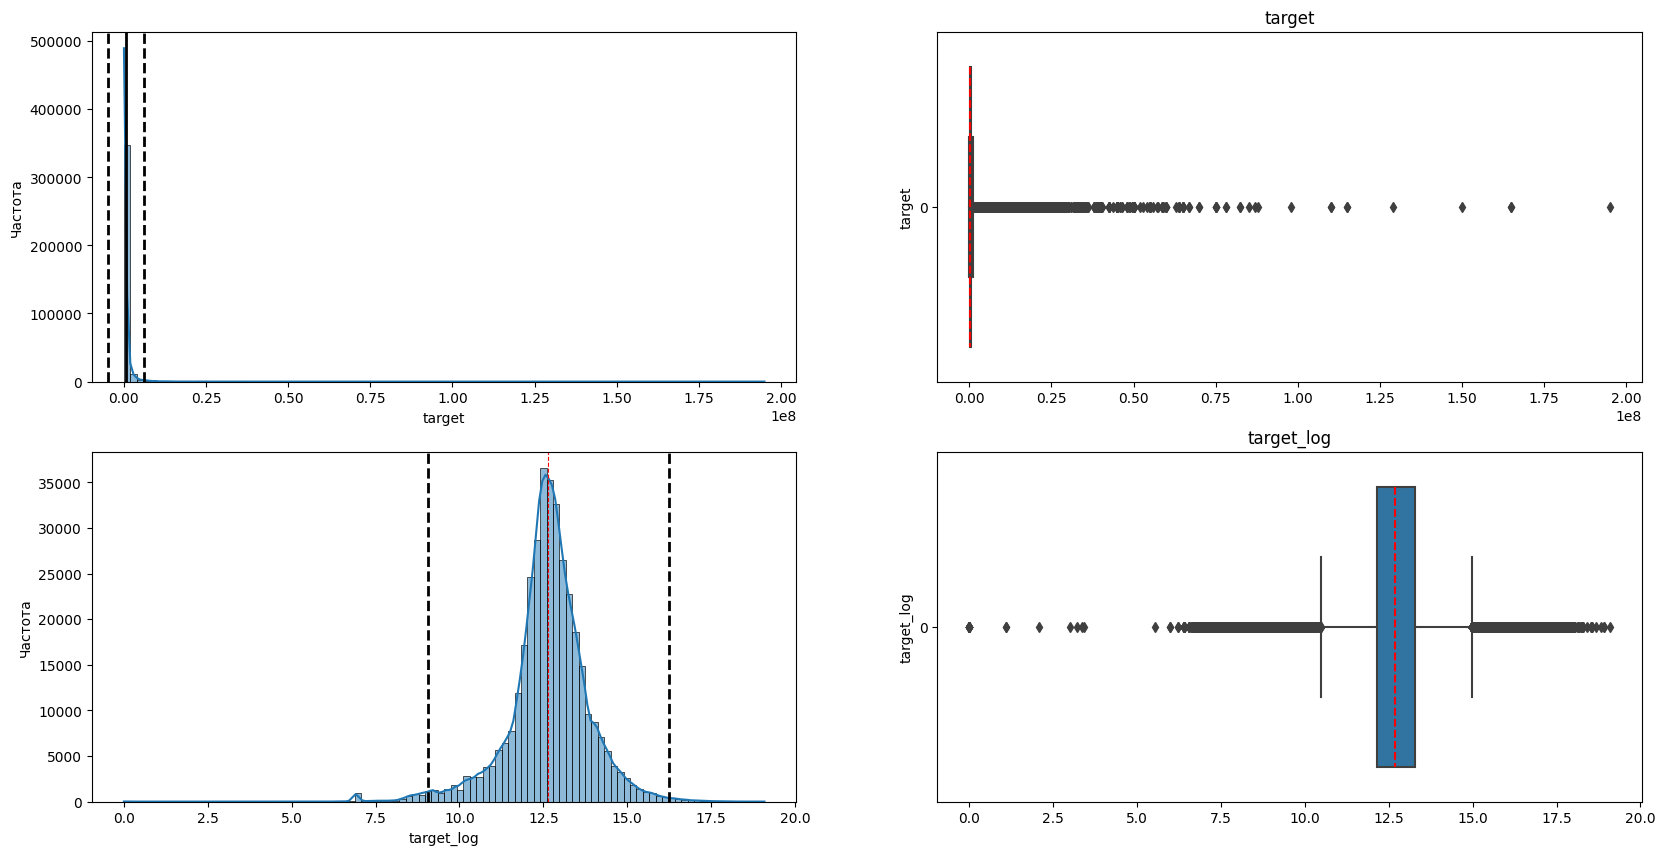

In [111]:
#напомним, как выглядела целевая переменная в обычном и в log масштабе

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

histplot1 = sns.histplot(df['target'], bins=100, kde= True, ax=axes[0,0])

histplot1.set(xlabel='target', ylabel='Частота')
histplot1.axvline(df['target'].mean(), color='red', linestyle='--', linewidth=0.8)
histplot1.axvline(df['target'].mean(), color='k', lw=2)
histplot1.axvline(df['target'].mean()+ 3 * df['target'].std(), color='k', ls='--', lw=2)
histplot1.axvline(df['target'].mean()- 3 * df['target'].std(), color='k', ls='--', lw=2)

boxplot1 = sns.boxplot(data['target'], ax=axes[0,1], orient='h', medianprops={"color": "red", "linestyle": '--'})
boxplot1.set(ylabel='target')
boxplot1.set_title('target')


histplot2 = sns.histplot(df['target_log'], bins=100, kde= True, ax=axes[1,0])
histplot2.set(xlabel='target_log', ylabel='Частота')
histplot2.axvline(df['target_log'].mean(), color='red', linestyle='--', linewidth=0.8)
histplot2.axvline(df['target_log'].mean()+ 3 * df['target_log'].std(), color='k', ls='--', lw=2)
histplot2.axvline(df['target_log'].mean()- 3 * df['target_log'].std(), color='k', ls='--', lw=2)

boxplot2 = sns.boxplot(df['target_log'], ax=axes[1,1], orient='h', medianprops={"color": "red", "linestyle": '--'})
boxplot2.set(ylabel='target_log')
boxplot2.set_title('target_log')


Разброс признаков существенный, поработаем над выбросами будем учитывать лог масштаб. Выше представлены границы 3х сигм, расширим границы при оценке выбросов до 4 сигм.

In [112]:
def outliers_z_score_mod(data, feature, log_scale=False, left = 3, right = 3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [113]:
outliers, cleaned = outliers_z_score_mod(df, 'target', log_scale=True, left =4 , right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 1535
Результирующее число записей: 363834


In [114]:
#удалим выбросы
df_n = cleaned

In [ ]:
### Обработка прочих признаков

<Axes: >

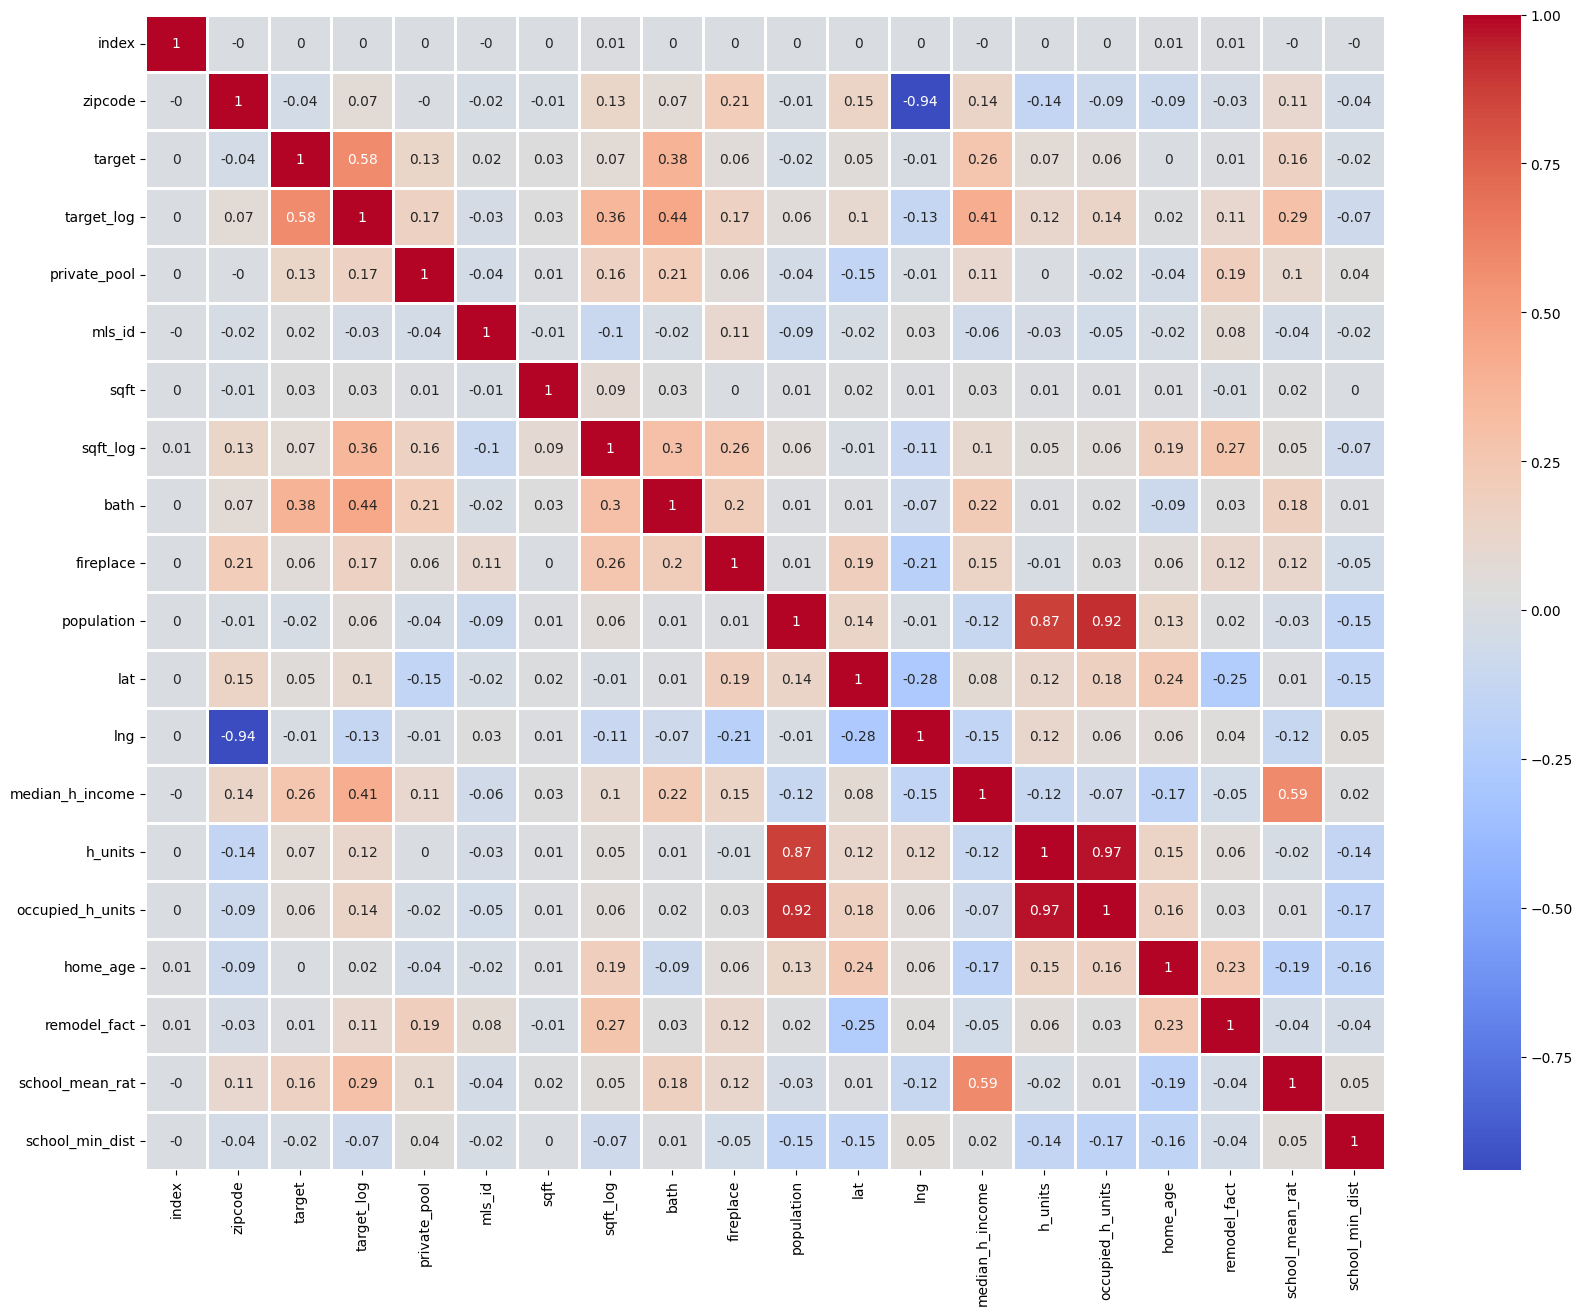

In [115]:
# Посмотрим на корреляцию текущих признаков (рассматриваем пока только количественные)

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(round(df_n.corr(numeric_only=True) ,2), annot = True, linewidths=.9, cmap='coolwarm')

Отметим для себя ряд высокоскоррелированных признаков (abs(0,75)), для того, чтобы принимать решение об их использовании:
-Population и h_units
-Population и occupied_h_units
-h_units and occupied_h_units
-zip-code and lng

А также есть существенная корреляция - 0.59 - между средним медианным доходом и рейтингом школ, что в общем-то логично

Также обратим внимание, на то, что есть существенная зависимость целевого признака с признаками:  sqrt_log, bath, median_h_income, school_mean_rat

Предлагаю: оставить признак Population
           zip-code к удалению (сделаю это чуть позднее)
           вместо признаков h_units and occupied_h_units создадим признак: доля занятых домовладений(occupied_h_units/h_units)

In [116]:
#cознадим признак
df_n['occupied_h_units_rate'] = df_n['occupied_h_units']/df['h_units']

C:\Users\User\AppData\Local\Temp\ipykernel_10340\3118145641.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



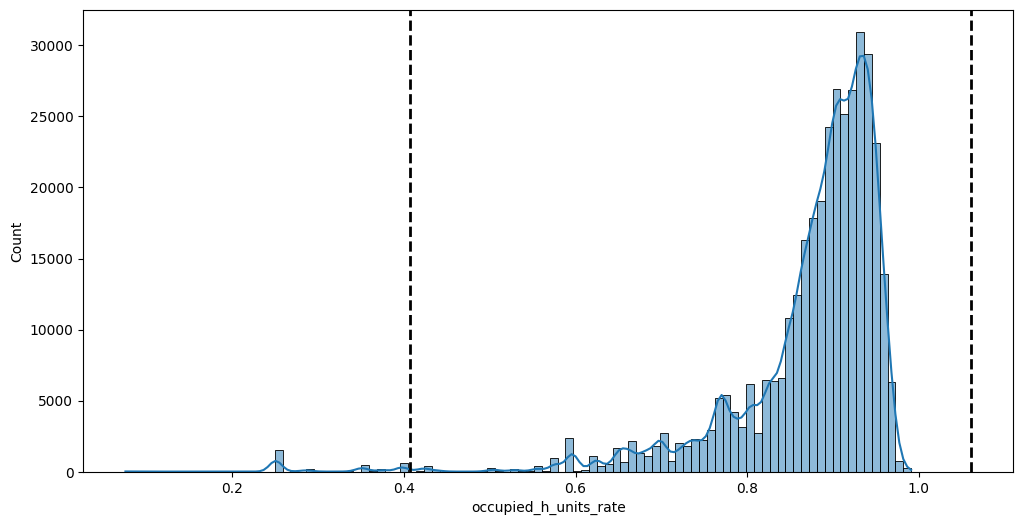

In [117]:
#посмотрим на распределение нового признака
hp =sns.histplot(df_n['occupied_h_units_rate'], bins=100, kde= True)
hp.axvline(df_n['occupied_h_units_rate'].mean()+ 2 * df_n['occupied_h_units_rate'].std(), color='k', ls='--', lw=2)
hp.axvline(df_n['occupied_h_units_rate'].mean()- 5 * df_n['occupied_h_units_rate'].std(), color='k', ls='--', lw=2)

In [118]:
#удалим не используемые
df_n = df_n.drop(['occupied_h_units','h_units'],axis=1)

In [119]:
#проверим есть ли корреляция между новым признаком и признаком population
df_n['occupied_h_units_rate'].corr(df_n['population'])

0.3240455790865336

Теперь обработаем выбросы, так как левый хвост распределения существенно больше правого будем использовать метод  z-отклонения, увеличив количество допустимых сигм левого хвоста

In [120]:
outliers, cleaned = outliers_z_score_mod(df_n, 'occupied_h_units_rate', log_scale=False, left = 5)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 2942
Результирующее число записей: 360892


In [121]:
#обработаем выбросы - заменим все значения менее 0.4 на минимум
df_n['occupied_h_units_rate'] = df_n['occupied_h_units_rate'].apply(lambda x: x if x>=0.4 else 0.4)

In [261]:
df_n

,index,zipcode,target,target_log,private_pool,mls_id,sqft,sqft_log,bath,fireplace,...,median_h_income,zip_major_city,status,property_type,home_age,remodel_fact,heating_system,school_mean_rat,school_min_dist,occupied_h_units_rate
0,0,28387,418000.0,12.943237,0,1,2900,7.972811,3.5,1,...,47982.0,others,active,single-family,3.0,0,OTHER,5.200000,2.70,0.869085
1,1,99216,310000.0,12.644328,0,1,1947,7.574558,3.0,0,...,45098.0,others,active,single-family,3.0,0,NO DATA,4.000000,1.01,0.930130
2,2,90049,2895000.0,14.878496,1,1,3000,8.006701,2.0,1,...,110854.0,Los Angeles,active,single-family,61.0,1,AIR,6.666667,1.19,0.920429
3,3,75205,2395000.0,14.688894,0,1,6457,8.773075,8.0,1,...,108913.0,Dallas,active,single-family,16.0,1,AIR,9.000000,0.10,0.902954
4,4,32908,5000.0,8.517193,0,1,0,0.000000,2.0,0,...,46466.0,others,active,land,0.0,0,NO HEATING NEED,4.666667,3.03,0.864539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365364,374405,20001,799000.0,13.591116,0,1,1417,7.257003,3.0,0,...,78848.0,Washington,active,condo,12.0,0,AIR,3.000000,0.10,0.879953
365365,374406,33180,1249000.0,14.037854,1,1,4017,8.298540,6.0,0,...,68317.0,Miami,not defined,single-family,32.0,1,OTHER,5.000000,1.10,0.698809
365366,374407,60657,674999.0,13.422466,0,1,2000,7.601402,3.0,0,...,75885.0,Chicago,active,condo,98.0,0,OTHER,4.333333,0.40,0.912784
365367,374408,11434,528000.0,13.176852,0,0,1152,7.050123,3.0,0,...,59229.0,others,active,single-family,72.0,1,OTHER,4.500000,0.48,0.933721


Посмотрим признак private_pool - ранее мы обнаруживали наличие некоторой зависимости цены от наличия бассейна.
Предлагаю проверить данную теорию с помощью статистичестического теста

Для выбора статистического критерия проверим, нормально ли распределена стоимость объекта в каждой из групп с помощью теста Шапиро-Уилка. Выдвигаются следующие гипотезы:

Нулевая гипотеза - распределение данные является нормальным.

Альтернативная гипотеза - распределение данных отлично от нормального.

In [122]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(df_n[df_n['private_pool']==0]['target'])
shapiro_result_b = shapiro(df_n[df_n['private_pool']==1]['target'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value с В', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе В отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе В является нормальным")

p-value группы А 0.0
p-value с В 0.0
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе В отлично от нормального


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



Итак, у нас 2 независимых группы с отличным от нормального распределением. В этих условиях выберем тест Манна-Уитни.

Выдвигаются следующие гипотезы:

Нулевая гипотеза -значения признака 'target' одинаковы для объектов с бассейном и без бассейна.

Альтернативная гипотеза - значения признака 'target' различны для объектов с бассейном и без бассейна.

In [123]:
# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# проводим тест
_, p = mannwhitneyu(df_n[df_n['private_pool']==0]['target'],
                          df_n[df_n['private_pool']==1]['target'],
                          alternative='two-sided')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Отлично, на заданном уровне значимости нулевая гипотеза опровергнута. Значения признака 'target' различны для объектов с бассейном и без бассейна.

Пришло время поработать с широтой и долготой. Созданим признак удаленность от столицы штата.

In [124]:
states_capitals = {'IA' : '41.6005,93.6091', 'ID' : '43.6154,-116.2047', 'LA' : '41.6005,-93.6091', 
                   'AL' : '44.4389,-93.5813', 'AK' : '58.3019,-134.42', 'AZ' : '33.4484,-112.074', 
                   'AR' : '34.7465,-92.2896', 'WY' : '41.1399,-104.8202', 'WA' : '47.0379,-122.901', 
                   'VT' : '44.2601,-72.5754', 'VA' : '37.5538,-77.4603', 'WI' : '41.2791,-72.5990', 
                   'HI' : '21.3069,-157.858', 'DE' : '39.1582,-75.5244', 'GA' : '33.749,-84.388', 
                   'WV' : '38.3498,-81.6326', 'IL' : '39.8017,-89.6437', 'IN' : '39.7684,-86.158', 
                   'CA' : '38.5816,-121.494', 'KS' : '39.0483,-95.678', 'KY' : '38.2009,-84.8733', 
                   'CO' : '39.7392,-104.985', 'CT' : '41.7637,-72.6851', 'LA' : '30.4508,-91.1545', 
                   'MA' : '42.3584,-71.0598', 'MN' : '44.9444,-93.0933', 'MS' : '32.2988,-90.1848', 
                   'MO' : '38.5767,-92.1735', 'MI' : '38.5767,-92.1735', 'MT' : '46.5927,-112.036', 
                   'ME' : '44.3106,-69.7795', 'MD' : '38.9785,-76.4922', 'NE' : '40.6767,-95.8592', 
                   'NV' : '39.1638,-119.767', 'NH' : '43.2081,-71.5376', 'NJ' : '40.217,-74.7429', 
                   'NY' : '42.6526,-73.7562', 'NM' : '35.687,-105.938', 'OH' : '39.9612,-82.9988', 
                   'OK' : '35.4676,-97.5164', 'OR' : '44.9429,-123.035', 'PA' : '40.2737,-76.8844', 
                   'RI' : '41.824,-71.4128', 'ND' : '46.8083,-100.784', 'NC' : '35.7721,-78.6386', 
                   'TN' : '36.1659,-86.7844', 'TX' : '30.2672,-97.7431', 'FL' : '30.4383,-84.2807', 
                   'SD' : '44.3683,-100.351', 'SC' : '34.0007,-81.0348', 'UT' : '40.7608,-111.891', 
                   'DC' : '38.8951,-77.0364'}

In [125]:
def get_capital_distance(lat, lng):
    distance = []
    
# если какой-то из координат нет - возвращаем пропуск
    if lat!= lat or lng!=lng: return np.nan
    lat1 = float(lat)
    lng1 = float(lng)

# вычисляем расстояние до каждой столицы штата и записываем в словарь
    for state in states_capitals:
        capital_coord = states_capitals[state].split(',')
        lat2 = float(capital_coord[0])
        lng2 = float(capital_coord[1])
        dist = haversine([lat1,lng1], [lat2,lng2], unit='mi')
        distance.append(dist)
        
# возвращаем минимальное расстояние
    result = min(distance)
    
    return result

In [126]:
df_n['сapital_dist'] = data.apply(lambda x: get_capital_distance(x['lat'], x['lng']), axis = 1)
df_n['сapital_dist'].describe()

count    363834.000000
mean        164.528556
std         123.691902
min           0.111020
25%          58.891522
50%         147.067894
75%         231.041884
max         413.691388
Name: сapital_dist, dtype: float64

In [127]:
#теперь удалим долготу и широту, и заодно еще индекс
df_n.drop(['lat','lng', 'zipcode'], inplace = True, axis = 1)

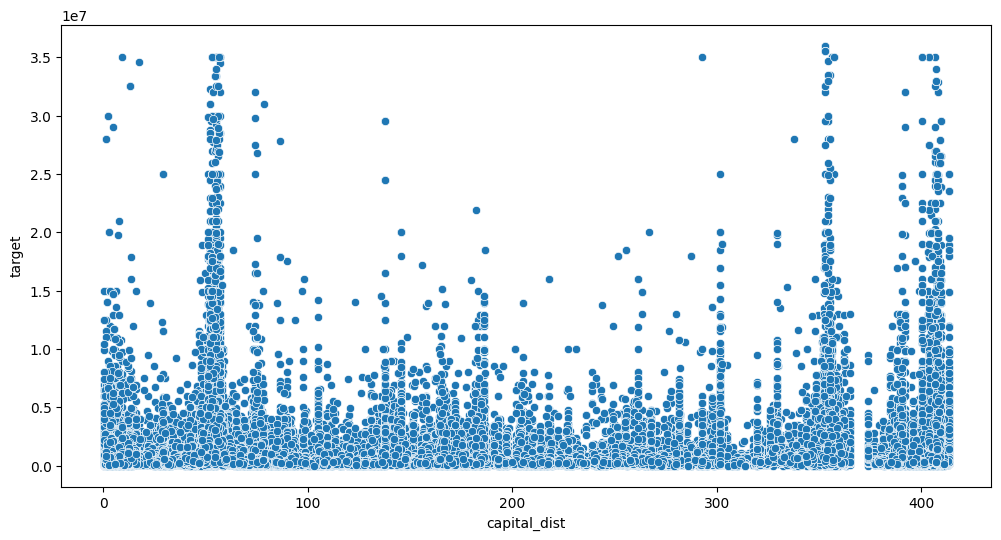

In [128]:
#посмотрим графически на есть ли какая-то зависимость
sns.scatterplot(data=df_n, x="сapital_dist", y="target");

Как будто бы не очень))) но пока оставим признак

In [269]:
df_n

,index,target,target_log,private_pool,mls_id,sqft,sqft_log,bath,fireplace,population,...,zip_major_city,status,property_type,home_age,remodel_fact,heating_system,school_mean_rat,school_min_dist,occupied_h_units_rate,сapital_dist
0,0,418000.0,12.943237,0,1,2900,7.972811,3.5,1,13921.0,...,others,active,single-family,3.0,0,OTHER,5.200000,2.70,0.869085,59.236749
1,1,310000.0,12.644328,0,1,1947,7.574558,3.0,0,24362.0,...,others,active,single-family,3.0,0,NO DATA,4.000000,1.01,0.930130,253.751913
2,2,2895000.0,14.878496,1,1,3000,8.006701,2.0,1,35482.0,...,Los Angeles,active,single-family,61.0,1,AIR,6.666667,1.19,0.920429,353.071299
3,3,2395000.0,14.688894,0,1,6457,8.773075,8.0,1,23061.0,...,Dallas,active,single-family,16.0,1,AIR,9.000000,0.10,0.902954,186.111547
4,4,5000.0,8.517193,0,1,0,0.000000,2.0,0,10892.0,...,others,active,land,0.0,0,NO HEATING NEED,4.666667,3.03,0.864539,275.580131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365364,374405,799000.0,13.591116,0,1,1417,7.257003,3.0,0,38551.0,...,Washington,active,condo,12.0,0,AIR,3.000000,0.10,0.879953,1.355530
365365,374406,1249000.0,14.037854,1,1,4017,8.298540,6.0,0,30840.0,...,Miami,not defined,single-family,32.0,1,OTHER,5.000000,1.10,0.698809,399.059890
365366,374407,674999.0,13.422466,0,1,2000,7.601402,3.0,0,65996.0,...,Chicago,active,condo,98.0,0,OTHER,4.333333,0.40,0.912784,169.086503
365367,374408,528000.0,13.176852,0,0,1152,7.050123,3.0,0,59129.0,...,others,active,single-family,72.0,1,OTHER,4.500000,0.48,0.933721,59.887965


Ранее мы уже фиксировали наличие штатов - чемпионов по ценам. (по крайне мере визуально.
Напомню: В штатах NY, MA, СA  (Нью-Йорк,Массачусетс, Калифорния) самые высокие средние цены на недвижимость

Предлагаю поступить также как и городами - сократить их количество в зависимости от частоты встречаемости

In [129]:
#cоздадим признак, который будет выводить только первые 10 по популярности городов, а остальные отправим в группу "others" (однако в отдельную группу не попадает штат Массачусетс)
df_n['state'].value_counts().head(10).to_dict().keys()

dict_keys(['FL', 'TX', 'NY', 'CA', 'NC', 'TN', 'WA', 'OH', 'NV', 'IL'])

In [130]:
df_n['state'] = df_n['state'].apply(lambda x: 'OTHERS' if x not in ['FL', 'TX', 'NY', 'CA', 'NC', 'TN', 'WA', 'OH', 'NV', 'IL'] else x)

[Text(0.5, 0, 'Штат'), Text(0, 0.5, 'Ср цена недвижимости')]

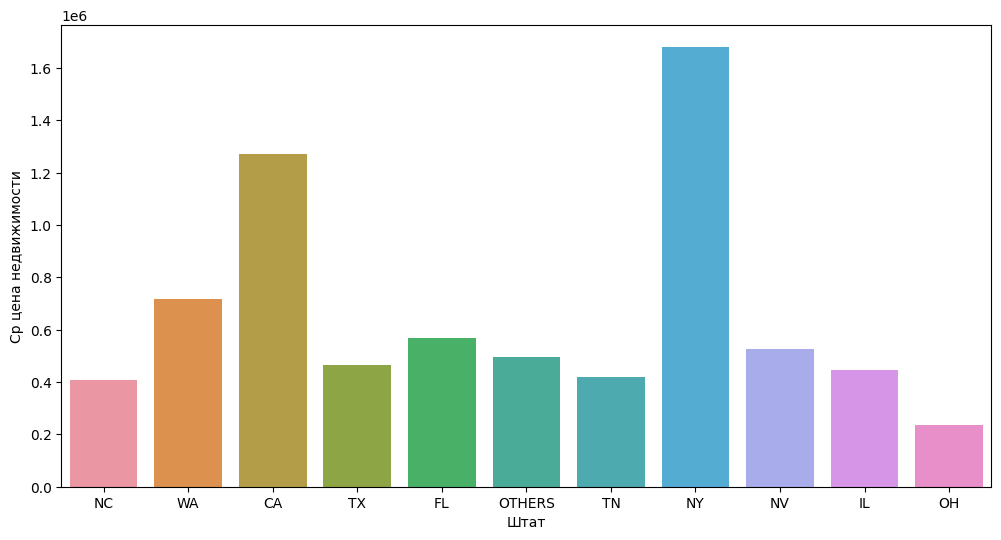

In [131]:
box = sns.barplot(x='state', y='target', data=df_n, estimator='mean', errorbar=None)
box.set(xlabel='Штат', ylabel='Ср цена недвижимости')

На этом больше не будем обрабатывать признак

Ранее выдвигалась теория, что наличие камина влияет на целевой признак, проверим это с помощью статистического теста

сначала проверим нормально ли распределение

Нулевая гипотеза - распределение данные является нормальным.
Альтернативная гипотеза - распределение данных отлично от нормального.

In [132]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(df_n[df_n['fireplace']==0]['target'])
shapiro_result_b = shapiro(df_n[df_n['fireplace']==1]['target'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value с В', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе В отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе В является нормальным")

p-value группы А 0.0
p-value с В 0.0
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе В отлично от нормального


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



Распределение отлично от нормально, признак количественный, 2 независимых группы - выбираем U-критерий Манна-Уитни для проверки различия в ценах объектов.

Выдвигаются следующие гипотезы:
Нулевая гипотеза  значения признака 'target' одинаковы для объектов с камином и без камина.
Альтернативная гипотеза значения признака 'target' различны для объектов с камином и без камина.

In [133]:
# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# проводим тест
_, p = mannwhitneyu(df_n[df_n['fireplace']==0]['target'],
                          df_n[df_n['fireplace']==1]['target'],
                          alternative='two-sided')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Успех, цены различны. Оставляем признак

Тот же самый подход используем и к признаку mls_id, все гипотезы сохраняются

In [134]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(df_n[df_n['mls_id']==0]['target'])
shapiro_result_b = shapiro(df_n[df_n['mls_id']==1]['target'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value с В', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе В отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе В является нормальным")

p-value группы А 0.0
p-value с В 0.0
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе В отлично от нормального


Можем также использовать тот же тест

In [135]:
# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# проводим тест
_, p = mannwhitneyu(df_n[df_n['mls_id']==0]['target'],
                          df_n[df_n['mls_id']==1]['target'],
                          alternative='two-sided')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


А вот тут неожиданно, и этот признак сохраним

На этом дополнительную обработку данных я заканчиваю, ввиду ограниченного количества времени на проект. Надеюсь мне удалось показать навык визуализации,обработки данных и работы со стат. тестами, а также навык генерации признаков

<Axes: >

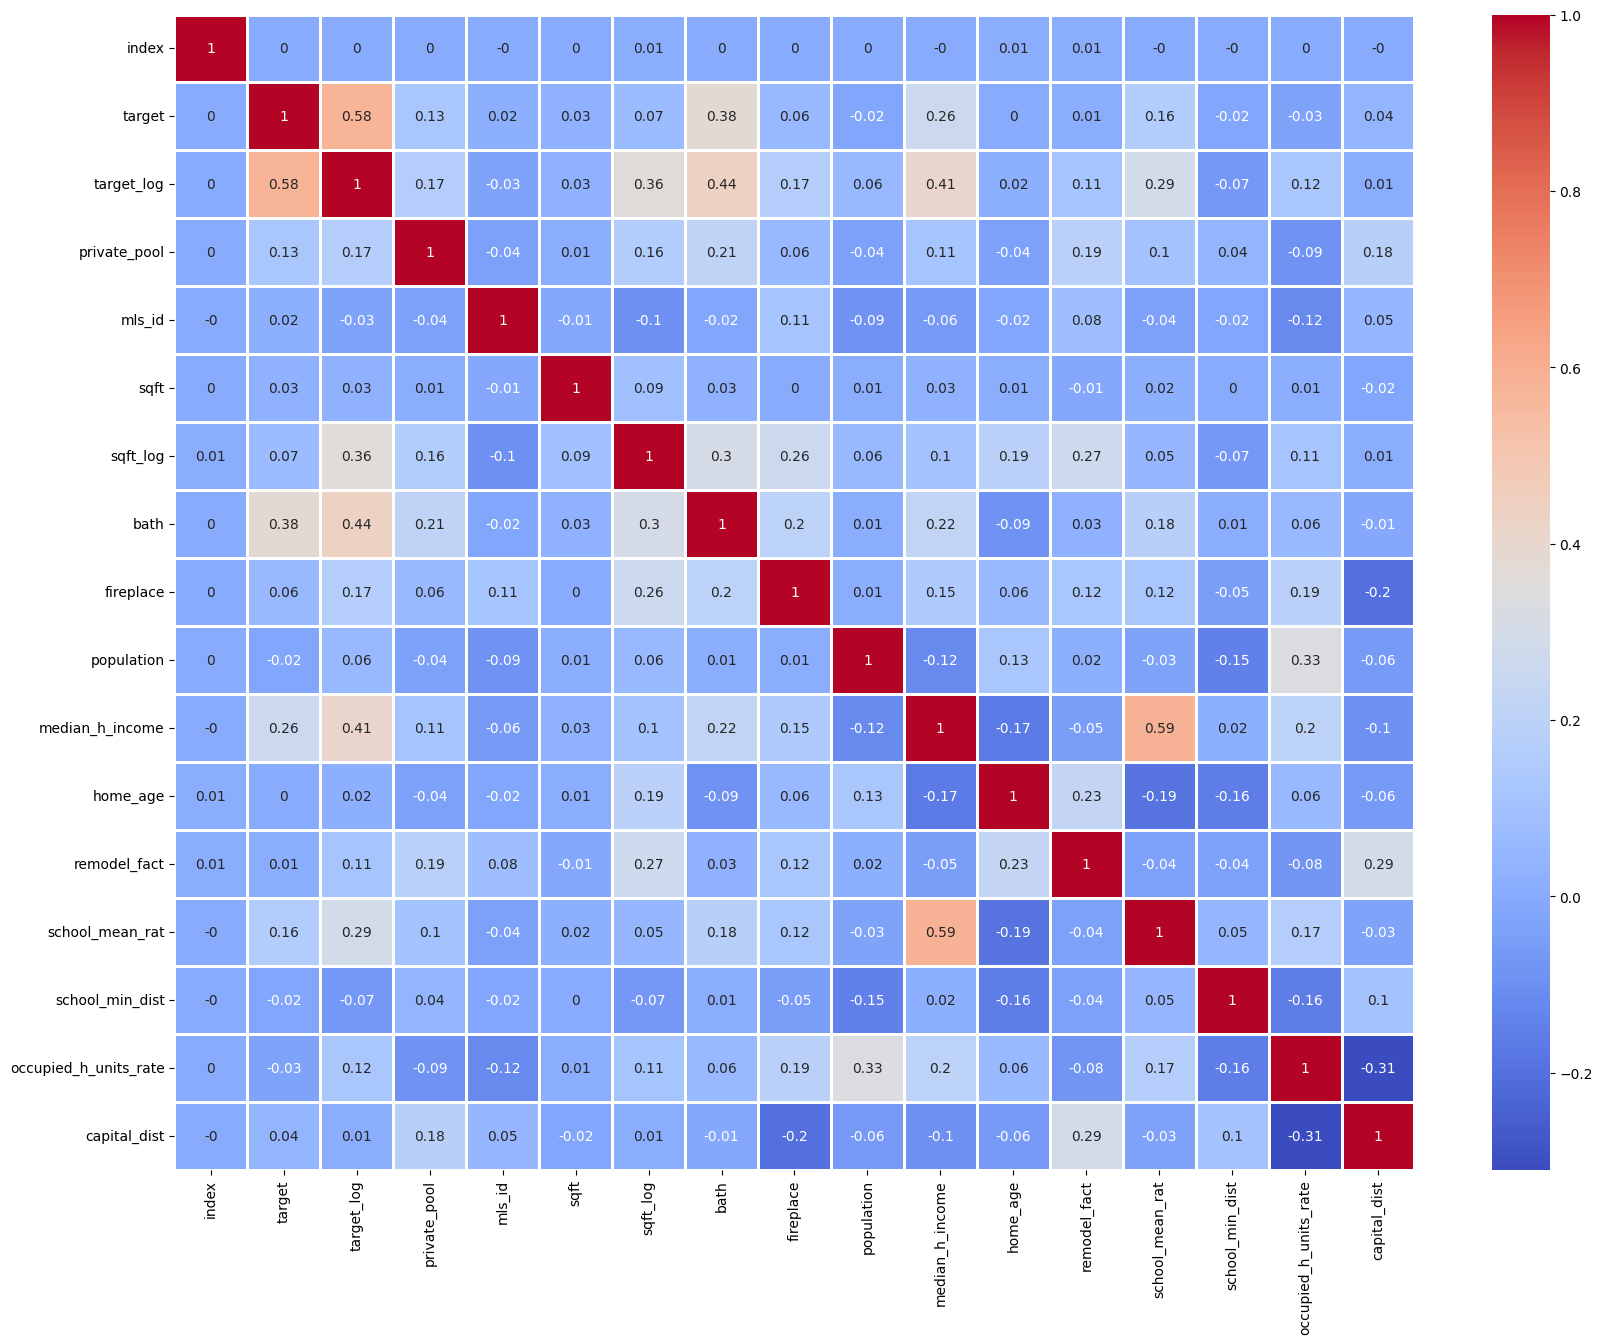

In [137]:
# Еще раз посмотрим на корреляцию текущих признаков (рассматриваем пока только количественные)

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(round(df_n.corr(numeric_only=True) ,2), annot = True, linewidths=.9, cmap='coolwarm')

In [138]:
df_n.to_csv('output\df_n.csv') 

In [181]:
df_new = pd.read_csv('output\df_n.csv') 

In [187]:
#для проверки роботоспособности модели
#к сожалению, из-за временных диапазонов у меня не получается воспроизвести полностью все преобразования, поэтому отщипну немного у готовых данных и в качестве учебных целей реализую попытку

for_test_data = df_new.sample(n=5)
for_test_data.to_csv('output/for_test_data.csv')
df_new = df_new[~df_new.index.isin(for_test_data.index)]
for_test_data

,Unnamed: 0,index,target,target_log,private_pool,mls_id,sqft,sqft_log,bath,fireplace,...,zip_major_city,status,property_type,home_age,remodel_fact,heating_system,school_mean_rat,school_min_dist,occupied_h_units_rate,сapital_dist
318491,319838,327236,292425.0,12.585964,1,0,1506,7.317876,2.0,1,...,Saint Petersburg,foreclosure,single-family,36.0,1,OTHER,5.000000,0.80,0.833435,205.079619
144612,145204,147637,375000.0,12.834681,0,1,725,6.587550,2.0,0,...,others,active,na,55.0,1,AIR,6.333333,0.40,0.665348,413.691388
255161,256220,261596,264900.0,12.487108,0,1,1862,7.529943,2.0,1,...,Fort Worth,active,single-family,6.0,0,AIR,6.000000,0.47,0.941982,176.782283
56912,57127,57837,274900.0,12.524163,0,1,729,6.593045,2.0,0,...,Miami,active,na,15.0,1,AIR,5.000000,0.60,0.894549,405.740714
205632,206481,210425,310990.0,12.647516,1,0,2254,7.720905,2.5,0,...,others,active,single-family,36.0,0,NO DATA,1.666667,2.34,0.929820,11.859646


Переходим к подготовке данных к моделированию

In [188]:
df_new

,Unnamed: 0,index,target,target_log,private_pool,mls_id,sqft,sqft_log,bath,fireplace,...,zip_major_city,status,property_type,home_age,remodel_fact,heating_system,school_mean_rat,school_min_dist,occupied_h_units_rate,сapital_dist
0,0,0,418000.0,12.943237,0,1,2900,7.972811,3.5,1,...,others,active,single-family,3.0,0,OTHER,5.200000,2.70,0.869085,59.236749
1,1,1,310000.0,12.644328,0,1,1947,7.574558,3.0,0,...,others,active,single-family,3.0,0,NO DATA,4.000000,1.01,0.930130,253.751913
2,2,2,2895000.0,14.878496,1,1,3000,8.006701,2.0,1,...,Los Angeles,active,single-family,61.0,1,AIR,6.666667,1.19,0.920429,353.071299
3,3,3,2395000.0,14.688894,0,1,6457,8.773075,8.0,1,...,Dallas,active,single-family,16.0,1,AIR,9.000000,0.10,0.902954,186.111547
4,4,4,5000.0,8.517193,0,1,0,0.000000,2.0,0,...,others,active,land,0.0,0,NO HEATING NEED,4.666667,3.03,0.864539,275.580131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363829,365364,374405,799000.0,13.591116,0,1,1417,7.257003,3.0,0,...,Washington,active,condo,12.0,0,AIR,3.000000,0.10,0.879953,1.355530
363830,365365,374406,1249000.0,14.037854,1,1,4017,8.298540,6.0,0,...,Miami,not defined,single-family,32.0,1,OTHER,5.000000,1.10,0.698809,399.059890
363831,365366,374407,674999.0,13.422466,0,1,2000,7.601402,3.0,0,...,Chicago,active,condo,98.0,0,OTHER,4.333333,0.40,0.912784,169.086503
363832,365367,374408,528000.0,13.176852,0,0,1152,7.050123,3.0,0,...,others,active,single-family,72.0,1,OTHER,4.500000,0.48,0.933721,59.887965


In [189]:
df_new = df_new.drop(['Unnamed: 0', 'index'], axis=1)

In [190]:
## Проведем первичную обработку данных 

#удалим дубликаты
print('Количество дубликатов: {}'.format(df_new[df_new.duplicated()].shape[0]))
df_new = df_new.drop_duplicates()
df_new.shape

Количество дубликатов: 41


(363788, 21)

In [191]:
#зафиксируем для удобства наличие пропусков
cols_null_percent = df_new.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: float64)

In [192]:
#проверим какие столбцы не являются числовыми, а значит требуют преобразования
object_columns = [col for col in df_new.columns
    if ((df_new[col].dtypes == 'object') | \
        (df_new[col].dtype.name == 'category') | \
        (df_new[col].dtypes == 'datetime64[ns]'))]

# смотрим, что попадает под преобразование
print(f'Преобразованию подлежит {len(object_columns)} столбцов с нечисловыми данными:')
object_columns

Преобразованию подлежит 5 столбцов с нечисловыми данными:


['state', 'zip_major_city', 'status', 'property_type', 'heating_system']

In [193]:
#закодируем категориальные признаки

encoder = ce.OneHotEncoder(cols=['state','zip_major_city', 'status','property_type', 'heating_system'] ) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df_new[['state','zip_major_city', 'status','property_type', 'heating_system']])
data_new = pd.concat([df_new, type_bin], axis=1)

In [194]:
#удалим колонки после категоризации
data_new = data_new.drop(['state','zip_major_city', 'status','property_type', 'heating_system'], axis = 1)

print('После преобразования получилось:', (data_new.shape[1]-2) ,'признаков')
#2 - это 2 вида целевого признака

После преобразования получилось: 79 признаков


In [195]:
#разделим выгрузку на обучающую и тестовую
X = data_new.drop(['target','target_log'], axis=1)
y_log = data_new['target_log']
y_abs = data_new['target']
X_train, X_test, y_train_log, y_test_log, y_train_abs, y_test_abs = model_selection.train_test_split(X, y_log, y_abs, test_size=0.3, random_state=42)
X_train.shape[0]

254651

In [196]:
X_train

,private_pool,mls_id,sqft,sqft_log,bath,fireplace,population,median_h_income,home_age,remodel_fact,...,property_type_9,property_type_10,property_type_11,heating_system_1,heating_system_2,heating_system_3,heating_system_4,heating_system_5,heating_system_6,heating_system_7
300149,0,1,1216,7.104144,3.0,0,3298.0,34981.0,36.0,0,...,0,0,0,0,0,1,0,0,0,0
84235,0,1,4432,8.396832,2.0,0,31407.0,63268.0,39.0,1,...,0,0,0,0,0,1,0,0,0,0
124981,0,1,2175,7.685244,3.0,1,14150.0,74834.0,28.0,0,...,0,0,0,0,0,1,0,0,0,0
226857,0,1,1740,7.462215,3.0,1,95137.0,62785.0,39.0,1,...,0,0,0,1,0,0,0,0,0,0
150035,0,1,1786,7.488294,2.0,0,57245.0,75599.0,59.0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119883,1,1,1367,7.221105,2.0,0,13833.0,54127.0,18.0,1,...,0,0,0,0,0,1,0,0,0,0
259200,0,1,1764,7.475906,2.0,0,22084.0,32310.0,61.0,1,...,0,0,0,1,0,0,0,0,0,0
131937,0,1,5068,8.530899,2.0,0,49635.0,51527.0,3.0,0,...,0,0,0,0,1,0,0,0,0,0
146876,0,1,2616,7.869784,2.0,1,46665.0,40989.0,56.0,1,...,0,0,0,1,0,0,0,0,0,0


In [197]:
#стандартизируем признаки
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Модель 2

In [198]:
#строим и обучаем модель линейной регрессии
model2 = linear_model.LinearRegression()
model2.fit(X_train_scaled, y_train_log)
y_predicted_train = model2.predict(X_train_scaled)
y_predicted_test = model2.predict(X_test_scaled)

In [199]:
y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

In [200]:
model2_mae_train = metrics.median_absolute_error(y_train_abs, y_predicted_train_abs)
model2_mae_test = metrics.median_absolute_error(y_test_abs, y_predicted_test_abs)

model2_r2_train = metrics.r2_score(y_train_log, y_predicted_train)
model2_r2_test = metrics.r2_score(y_test_log, y_predicted_test)

print('MAE 2 модели train: %.3f' % model2_mae_train)
print('MAE 2 модели test: %.3f' % model2_mae_test)

print('R^2 2 модели train: %.3f' % model2_r2_train)
print('R^2 2 модели test: %.3f' % model2_r2_test)


MAE 2 модели train: 103581.128
MAE 2 модели test: 104080.043
R^2 2 модели train: 0.555
R^2 2 модели test: 0.558


Увы качество модели ухудшилось, она ошибается на большие суммы, коэффициент детерминации ниже. Попробуем поработать над признаками

Признакy у нас теперь 79, поэтому красиво не визуализируем.
Выведем попарные корреляции признаков

In [201]:
# целевой признак
y_for_corr = y_log

# все признаки, по которым будем считать корреляцию
data = pd.merge(X, y_for_corr, left_index=True, right_index=True)

# построим корряляционную матрицу и развернем ее в датасет спискок
corr = data.corr()
corr_desc = corr.abs().unstack()
corr_desc = pd.DataFrame(corr_desc).reset_index()
corr_desc = corr_desc.rename(columns = {'level_0': 'feature_a', 'level_1': 'feature_b', 0: 'corr'})

# выдели в отдельный датасет корреляцию предикторов с целевым признаком
corr_with_y = corr_desc[(corr_desc['feature_b']=='target_log') & (corr_desc['feature_a']!='target_log') ]
corr_with_y.drop('feature_b', axis = 1, inplace = True)

# в другом датасете оставим только корреялции предикторов друг с другом
corr_desc = corr_desc[(corr_desc['feature_a']!='target_log') & (corr_desc['feature_b']!='target_log')]
corr_desc = corr_desc[(corr_desc['feature_a']!=corr_desc['feature_b'])]

# объединим таблицы корреляций таким образом, чтобы к каждой паре признаков были добавлены корреляции этих признаков с целевой переменной
corr_fin = pd.merge(corr_desc,
                    corr_with_y,
                    on = 'feature_a')
corr_fin = pd.merge(corr_fin,
                   corr_with_y,
                   left_on ='feature_b',
                   right_on = 'feature_a')
corr_fin.drop('feature_a_y', axis = 1, inplace = True)

# переименуем столбцы для более легкой интерпретации
corr_fin = corr_fin.rename(columns = {'feature_a_x': 'feature_a',
                                      'corr_x': 'a_b_corr',
                                      'corr_y': 'a_y_corr',
                                      'corr': 'b_y_corr'})
corr_fin

C:\Users\User\AppData\Local\Temp\ipykernel_10340\163419986.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,feature_a,feature_b,a_b_corr,a_y_corr,b_y_corr
0,private_pool,mls_id,0.039417,0.171927,0.029633
1,sqft,mls_id,0.011473,0.033586,0.029633
2,sqft_log,mls_id,0.101099,0.362859,0.029633
3,bath,mls_id,0.015976,0.444881,0.029633
4,fireplace,mls_id,0.106617,0.174300,0.029633
...,...,...,...,...,...
6157,heating_system_3,private_pool,0.189436,0.093599,0.171927
6158,heating_system_4,private_pool,0.099793,0.353915,0.171927
6159,heating_system_5,private_pool,0.056363,0.005866,0.171927
6160,heating_system_6,private_pool,0.041963,0.015199,0.171927


В результате получили датафрейм, в котором представлены: предиктор a, предиктор b, между которыми оценили корреляцию a_b_corr, а также из корреляцию с целевым признаком (a_y_corr и b_y_corr соответственно). Теперь будем отбирать предикторы с корреляцией между другом более 0.7 (все коэффициенты в датафрейме указаны по модулю), и из пары предикторов оставим тот, для которого соответствующий ему коэффициент корреляции с целевой переменной больше:

In [202]:
def select_feature_for_del(df):
    feature_a = df['feature_a']
    feature_b = df['feature_b']
    a_b_corr = df['a_b_corr']
    a_y_corr = df['a_y_corr']
    b_y_corr = df['b_y_corr']
    for_del = np.nan
    
# если корреляция между предикторами больше 0.7, выбираем для удаления тот, у которого корреляция с целевой переменной ниже
    if a_b_corr >=0.7:
        if a_y_corr > b_y_corr:
            for_del = feature_b
        if a_y_corr < b_y_corr:
            for_del = feature_a
        else:
            for_del = feature_b
    return for_del

# применим функцию
corr_fin['for_del'] = corr_fin.apply(select_feature_for_del, axis = 1)

corr_fin[(corr_fin['a_b_corr']>=0.7)]

,feature_a,feature_b,a_b_corr,a_y_corr,b_y_corr,for_del
1677,zip_major_city_16,state_9,0.844375,0.010207,0.016548,zip_major_city_16
1760,zip_major_city_21,state_10,0.869343,0.014726,0.028988,zip_major_city_21
3064,state_9,zip_major_city_16,0.844375,0.016548,0.010207,zip_major_city_16
3455,state_10,zip_major_city_21,0.869343,0.028988,0.014726,zip_major_city_21
3951,status_2,status_1,0.746010,0.037396,0.000926,status_1
4029,status_1,status_2,0.746010,0.000926,0.037396,status_1
4832,heating_system_4,property_type_2,1.000000,0.353915,0.353915,property_type_2
5834,property_type_2,heating_system_4,1.000000,0.353915,0.353915,heating_system_4


Теперь составим список признаков для удаления:

In [203]:
features_for_del = set(corr_fin[corr_fin['for_del']==corr_fin['for_del']]['for_del'])
features_for_del = list(features_for_del)
features_for_del

['status_1',
 'heating_system_4',
 'zip_major_city_21',
 'zip_major_city_16',
 'property_type_2']

Удалим из датафрейма избыточные предикторы:

In [204]:
X.drop(features_for_del, axis=1, inplace = True)


In [ ]:
#в ходе итераций обнаружила, что почему-то остались 2 признака 'sqft', и 'sqft_log',
#принудительно дропну 'sqft'

In [205]:
X.drop('sqft', axis=1, inplace = True)

In [206]:
final_features = list(X.columns)

In [207]:
final_features

['private_pool',
 'mls_id',
 'sqft_log',
 'bath',
 'fireplace',
 'population',
 'median_h_income',
 'home_age',
 'remodel_fact',
 'school_mean_rat',
 'school_min_dist',
 'occupied_h_units_rate',
 'сapital_dist',
 'state_1',
 'state_2',
 'state_3',
 'state_4',
 'state_5',
 'state_6',
 'state_7',
 'state_8',
 'state_9',
 'state_10',
 'state_11',
 'zip_major_city_1',
 'zip_major_city_2',
 'zip_major_city_3',
 'zip_major_city_4',
 'zip_major_city_5',
 'zip_major_city_6',
 'zip_major_city_7',
 'zip_major_city_8',
 'zip_major_city_9',
 'zip_major_city_10',
 'zip_major_city_11',
 'zip_major_city_12',
 'zip_major_city_13',
 'zip_major_city_14',
 'zip_major_city_15',
 'zip_major_city_17',
 'zip_major_city_18',
 'zip_major_city_19',
 'zip_major_city_20',
 'zip_major_city_22',
 'zip_major_city_23',
 'zip_major_city_24',
 'zip_major_city_25',
 'zip_major_city_26',
 'status_2',
 'status_3',
 'status_4',
 'status_5',
 'status_6',
 'status_7',
 'status_8',
 'status_9',
 'status_10',
 'property_type_1

### Модель 3

In [208]:
#разделим выгрузку на обучающую и тестовую
X = X
y_log = data_new['target_log']
y_abs = data_new['target']
X_train, X_test, y_train_log, y_test_log, y_train_abs, y_test_abs = model_selection.train_test_split(X, y_log, y_abs, test_size=0.3, random_state=42)
X_train.shape[0]

254651

In [209]:
#стандартизируем
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [210]:
#строим и обучаем модель линейной регрессии
model3 = linear_model.LinearRegression()
model3.fit(X_train_scaled, y_train_log)
y_predicted_train = model3.predict(X_train_scaled)
y_predicted_test = model3.predict(X_test_scaled)

In [211]:
y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

In [212]:
model3_mae_train = metrics.median_absolute_error(y_train_abs, y_predicted_train_abs)
model3_mae_test = metrics.median_absolute_error(y_test_abs, y_predicted_test_abs)

model3_r2_train = metrics.r2_score(y_train_log, y_predicted_train)
model3_r2_test = metrics.r2_score(y_test_log, y_predicted_test)

print('MAE 3 модели train: %.3f' % model3_mae_train)
print('MAE 3 модели test: %.3f' % model3_mae_test)

print('R^2 3 модели train: %.3f' % model3_r2_train)
print('R^2 3 модели test: %.3f' % model3_r2_test)

MAE 3 модели train: 104091.637
MAE 3 модели test: 104790.181
R^2 3 модели train: 0.554
R^2 3 модели test: 0.557


### Модель 4

Попробуем улучшить качество  модели, взяв только значимые факторы. Для этого воспользуемся методов SelectKbest.

In [213]:
selector = SelectKBest(f_regression, k='all').fit(X_train_scaled, y_train_log)
scores = selector.scores_
feature_importances = pd.DataFrame(scores, X_train.columns[0:len(X_train.columns)]).reset_index()
feature_importances = (feature_importances.rename(columns = {'index': 'feature', 0:'score'})).sort_values(by = 'score', ascending= False)

feature_importances

,feature,score
3,bath,62054.156054
6,median_h_income,51807.046016
2,sqft_log,38488.695583
9,school_mean_rat,23199.262211
20,state_8,12603.175100
...,...,...
58,property_type_3,5.842332
66,property_type_11,3.508173
56,status_10,1.253876
29,zip_major_city_6,0.172710


Text(28.347222222222214, 0.5, 'Значение скора')

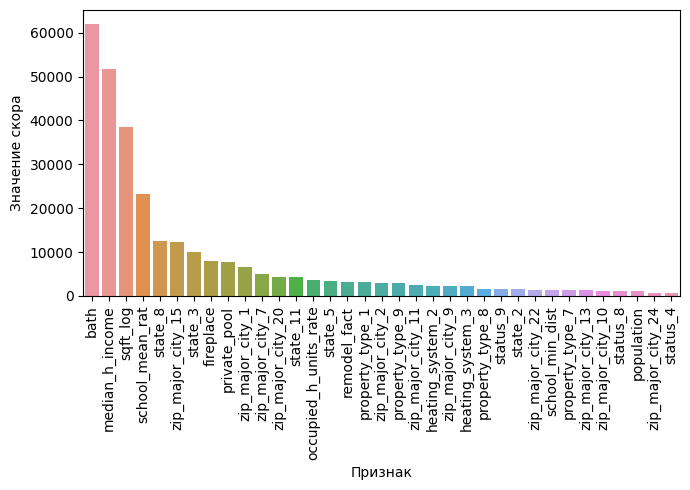

In [214]:
fig, ax = plt.subplots(figsize=(7,5))
fig = sns.barplot(x='feature', y='score', data=feature_importances.head(35), estimator='mean', errorbar=None)
plt.xticks(rotation=90)
plt.tight_layout()
ax.set_xlabel("Признак")
ax.set_ylabel("Значение скора")


Оставим все признаки до "heating_system_3" включительно, тк после него идет падение скора больше чем в 2 раза

In [215]:
#Посмотрим для подтверждения на табличку
feature_importances.head(25)

,feature,score
3,bath,62054.156054
6,median_h_income,51807.046016
2,sqft_log,38488.695583
9,school_mean_rat,23199.262211
20,state_8,12603.175100
38,zip_major_city_15,12330.676925
15,state_3,9940.631288
4,fireplace,8051.796750
0,private_pool,7730.761970
24,zip_major_city_1,6495.679376


In [216]:
selector = SelectKBest(f_regression, k=23).fit(X_train_scaled, y_train_log)
selected = selector.get_feature_names_out()

In [217]:
X_train_scaled_best = X_train_scaled[selected]
X_test_scaled_best = X_test_scaled[selected]

In [218]:
#строим и обучаем модель линейной регрессии
model4 = linear_model.LinearRegression()
model4.fit(X_train_scaled_best, y_train_log)
y_predicted_train = model4.predict(X_train_scaled_best)
y_predicted_test = model4.predict(X_test_scaled_best)

In [219]:
y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

In [220]:
model4_mae_train = metrics.median_absolute_error(y_train_abs, y_predicted_train_abs)
model4_mae_test = metrics.median_absolute_error(y_test_abs, y_predicted_test_abs)

model4_r2_train = metrics.r2_score(y_train_log, y_predicted_train)
model4_r2_test = metrics.r2_score(y_test_log, y_predicted_test)

print('MAE 4 модели train: %.3f' % model4_mae_train)
print('MAE 4 модели test: %.3f' % model4_mae_test)

print('R^2 4 модели train: %.3f' % model4_r2_train)
print('R^2 4 модели test: %.3f' % model4_r2_test)

MAE 4 модели train: 114870.716
MAE 4 модели test: 115418.136
R^2 4 модели train: 0.501
R^2 4 модели test: 0.505


Улучшить результаты не получилось.
Однако будем пока ориентироваться на модель 3 - как основную, так как в ней скорректированы важные моменты, особенно - исключены сильно скоррелированные признаки!

### Модель 5. Полиномиальная регрессия
(сразу с регуляризацией, тк полиномиальные регрессии склонны к переобучению) и с первыми 23 признаками, тк у меня недостаточно оперативной памяти

In [221]:
#создадим полиномиальные признаки
poly = preprocessing.PolynomialFeatures(include_bias=False)
poly.fit(X_train_scaled_best)

X_train_poly = poly.transform(X_train_scaled_best)
X_test_poly = poly.transform(X_test_scaled_best)

In [222]:
model5 = linear_model.Ridge(alpha=0.2)
model5.fit(X_train_poly, y_train_log)

y_predicted_train = model5.predict(X_train_poly)
y_predicted_test = model5.predict(X_test_poly)

In [223]:
y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

model5_mae_train = metrics.median_absolute_error(y_train_abs, y_predicted_train_abs)
model5_mae_test = metrics.median_absolute_error(y_test_abs, y_predicted_test_abs)

model5_r2_train = metrics.r2_score(y_train_log, y_predicted_train)
model5_r2_test = metrics.r2_score(y_test_log, y_predicted_test)

print('MAE 5 модели train: %.3f' % model5_mae_train)
print('MAE 5 модели test: %.3f' % model5_mae_test)

print('R^2 5 модели train: %.3f' % model5_r2_train)
print('R^2 5 модели test: %.3f' % model5_r2_test)



MAE 5 модели train: 100708.315
MAE 5 модели test: 100927.410
R^2 5 модели train: 0.601
R^2 5 модели test: 0.604


Ура! несмотря на то, что пришлось взять только 23 базовых признака качество модели улучшилось. Зато модель не подвергается значимой проблеме переобучения

### Модель 6. Дерево решений
(поиск оптимальных значений произведем с помоцью RamdomizedSearch)

In [224]:
# сетка параметров для перебора
param_distributions = {'min_samples_leaf': list(np.linspace(10, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 15, dtype=int))
              
              }

# механизм перебора
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)

# выполним сам перебор
random_search_tree.fit(X_train_scaled, y_train_log) 

# и выведем результат
y_test_pred = random_search_tree.predict(X_test_scaled)
print('R2 на тестовом наборе: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

R2 на тестовом наборе: 0.76
Наилучшие значения гиперпараметров: {'min_samples_leaf': 19, 'max_depth': 19}


In [225]:
model6 = tree.DecisionTreeRegressor(random_state=42, min_samples_leaf = 19, max_depth = 19)
model6.fit(X_train_scaled, y_train_log)

# Предсказания на обучающих и тестовых данных
y_predicted_train = model6.predict(X_train_scaled)
y_predicted_test = model6.predict(X_test_scaled)

# Вычисляем метрики
y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

model6_mae_train = metrics.median_absolute_error(y_train_abs, y_predicted_train_abs)
model6_mae_test = metrics.median_absolute_error(y_test_abs, y_predicted_test_abs)

model6_r2_train = metrics.r2_score(y_train_log, y_predicted_train)
model6_r2_test = metrics.r2_score(y_test_log, y_predicted_test)

print('MAE 6 модели train: %.3f' % model6_mae_train)
print('MAE 6 модели test: %.3f' % model6_mae_test)

print('R^2 6 модели train: %.3f' % model6_r2_train)
print('R^2 6 модели test: %.3f' % model6_r2_test)

MAE 6 модели train: 57127.918
MAE 6 модели test: 62498.568
R^2 6 модели train: 0.798
R^2 6 модели test: 0.756


Решающее дерево с подбором параметров методом RandomizedSearchCV прекрасно улучшило результат результат - коэффициент детерминации на тестовой выборке увеличился до 0.756, а медианная ошибка снизилась до 62498.9 USD
Однако, так как дерево достаточно глубокое - модель все же переобучена

### Модель 7. Случайный лес
(поиск оптимальных значений проведем с помощью оптуны)

In [226]:
def optuna_rfr(trial):
# задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 10, 100, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 100, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    criterion = trial.suggest_categorical('criterion', ['poisson', 'squared_error'])
    random_state = 42

# создаем модель
    model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
# обучаем модель
    model.fit(X_train_scaled, y_train_log)

# фиксируем метрики r2
    score = metrics.r2_score(y_train_log, model.predict(X_train_scaled))

    return score

In [228]:
def optuna_rf(trial, random_state=42):
# задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 5, 100, 5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 95, 10)
    max_depth = trial.suggest_int('max_depth', 10, 25, 1)
    max_features = trial.suggest_int('max_features', 5, 77, 3)
    

# создаем модель
    model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state,
                                          max_features = max_features)
# обучаем модель
    model.fit(X_train_scaled, y_train_log)

# фиксируем метрики r2
    score = metrics.r2_score(y_train_log, model.predict(X_train_scaled))

    return score

In [229]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2024-05-17 09:29:56,264] A new study created in memory with name: RandomForestRegressor
[I 2024-05-17 09:31:16,943] Trial 0 finished with value: 0.7981198823446793 and parameters: {'n_estimators': 95, 'min_samples_leaf': 25, 'max_depth': 21, 'max_features': 20}. Best is trial 0 with value: 0.7981198823446793.
[I 2024-05-17 09:31:32,425] Trial 1 finished with value: 0.6706013034889069 and parameters: {'n_estimators': 55, 'min_samples_leaf': 55, 'max_depth': 12, 'max_features': 8}. Best is trial 0 with value: 0.7981198823446793.
[I 2024-05-17 09:32:01,922] Trial 2 finished with value: 0.7286608355591078 and parameters: {'n_estimators': 80, 'min_samples_leaf': 15, 'max_depth': 15, 'max_features': 8}. Best is trial 0 with value: 0.7981198823446793.
[I 2024-05-17 09:34:35,252] Trial 3 finished with value: 0.7752928735518557 and parameters: {'n_estimators': 90, 'min_samples_leaf': 65, 'max_depth': 25, 'max_features': 47}. Best is trial 0 with value: 0.7981198823446793.
[I 2024-05-17 09:36

In [230]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 50, 'min_samples_leaf': 5, 'max_depth': 25, 'max_features': 41}


In [231]:
#Создаем объект класса случайного леса
model7 = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 5, max_depth = 25, max_features = 41, random_state = 42)

#Обучаем лес
model7.fit(X_train_scaled, y_train_log)

 
y_predicted_train = model7.predict(X_train_scaled)
y_predicted_test = model7.predict(X_test_scaled)

y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

# Вычисляем метрики
y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

model7_mae_train = metrics.median_absolute_error(y_train_abs, y_predicted_train_abs)
model7_mae_test = metrics.median_absolute_error(y_test_abs, y_predicted_test_abs)

model7_r2_train = metrics.r2_score(y_train_log, y_predicted_train)
model7_r2_test = metrics.r2_score(y_test_log, y_predicted_test)

print('MAE 7 модели train: %.3f' % model7_mae_train)
print('MAE 7 модели test: %.3f' % model7_mae_test)

print('R^2 7 модели train: %.3f' % model7_r2_train)
print('R^2 7 модели test: %.3f' % model7_r2_test)

MAE 7 модели train: 34146.358
MAE 7 модели test: 44349.173
R^2 7 модели train: 0.883
R^2 7 модели test: 0.825


Супер результат получился! Но все же некоторое переобучение присутствует

In [233]:
#посмотрим на самые важные параметры
optuna.visualization.plot_param_importances(study, target_name="r2_score")

### Модель 8. Градиентный бустинг над деревьями решений


In [234]:
model8 = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=4,
                                         n_estimators=200, 
                                         min_samples_split = 20,
                                         random_state=42 
                                         )


model8.fit(X_train_scaled, y_train_log)

 
y_predicted_train = model8.predict(X_train_scaled)
y_predicted_test = model8.predict(X_test_scaled)

y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

# Вычисляем метрики
y_predicted_train_abs = np.exp(y_predicted_train)
y_predicted_test_abs = np.exp(y_predicted_test)

model8_mae_train = metrics.median_absolute_error(y_train_abs, y_predicted_train_abs)
model8_mae_test = metrics.median_absolute_error(y_test_abs, y_predicted_test_abs)

model8_r2_train = metrics.r2_score(y_train_log, y_predicted_train)
model8_r2_test = metrics.r2_score(y_test_log, y_predicted_test)

print('MAE 8 модели train: %.3f' % model8_mae_train)
print('MAE 8 модели test: %.3f' % model8_mae_test)

print('R^2 8 модели train: %.3f' % model8_r2_train)
print('R^2 8 модели test: %.3f' % model8_r2_test)

MAE 8 модели train: 56442.470
MAE 8 модели test: 58192.969
R^2 8 модели train: 0.809
R^2 8 модели test: 0.798


<Axes: >

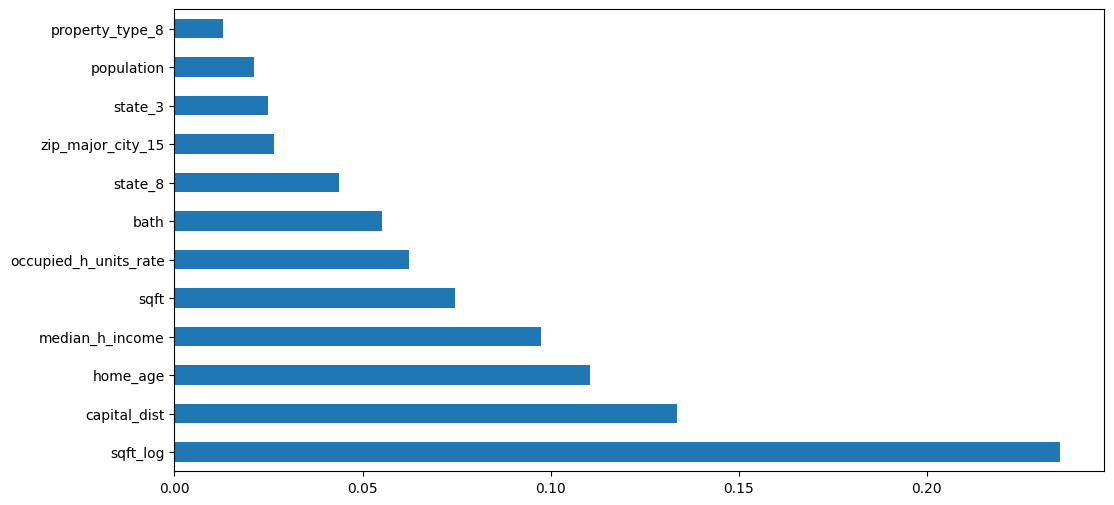

In [81]:
# посмотрим на важнейшие признаки для данной модели через атрибут feature_importances_
plt.rcParams['figure.figsize'] = (12,6)
feat_importances = pd.Series(model8.feature_importances_, index=X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')

1) линейная регрессия со всеми переменными и стандартными параметрами
MAE базовой модели train: 98651.410
MAE базовой модели test: 98063.464
R^2 базовой модели train: 0.584
R^2 базовой модели test: 0.588

2)линейная регрессия с учетом доп обработки данных и стандартными параметрами
MAE 2 модели train: 103532.717
MAE 2 модели test: 103283.615
R^2 2 модели train: 0.555
R^2 2 модели test: 0.558

3) модель регрессии с учетом доп обработки данных, очистки скоррелированных данных и стандартными параметрами

MAE 3 модели train: 104091.637
MAE 3 модели test: 104790.181
R^2 3 модели train: 0.554
R^2 3 модели test: 0.557


4) модель регрессии с учетом доп обработки данных, очистки скоррелированных данных и стандартными параметрами топ 23 признака по значимости

MAE 4 модели train: 114870.716
MAE 4 модели test: 115418.136
R^2 4 модели train: 0.501
R^2 4 модели test: 0.505

5)модель полиномиальной регрессии с l2_регуляризацию (Из-за нехватки оперативной памяти посчитана модель только на первых 23 признаках по значимости)  

MAE 5 модели train: 100708.315
MAE 5 модели test: 100927.410
R^2 5 модели train: 0.601
R^2 5 модели test: 0.604

6) модель 6 дерево решений c поиском параметров

MAE 6 модели train: 57127.918
MAE 6 модели test: 62498.568
R^2 6 модели train: 0.798
R^2 6 модели test: 0.756

7) модель 7 случайный лес с поиском параметров

MAE 7 модели train: 34146.358
MAE 7 модели test: 44349.173
R^2 7 модели train: 0.883
R^2 7 модели test: 0.825

8) модель 8 градиентный бустинг над деревьями решений

MAE 8 модели train: 56442.470
MAE 8 модели test: 58192.969
R^2 8 модели train: 0.809
R^2 8 модели test: 0.798


В рамках проекта были обучены 8 различных моделей, это далеко не все, что возможно использовать для постоения моделей. Не вошли в исследования, например, алготитмы беггинга и стекинга.
Однако, считаю полученные результаты удовлетворительными. Одной из лучших моделей оказалась модель 6 - простое дерево решений, с параметрами, подобранными через RandomSearch. 
Лучшей моделью является случайный лес с подобранными параметраи, однако, в ней, на мой взглд, наблюдается переобучение.
Поэтому остановимся на градиентном бустинге.

Коэффициент детерминации на тестовых данных - 80%, абсолютная ошибка 58192.969 USD. Что с учетом огромного разброса цен в представленном датасете - выглядит вполне приемлемо.

Сохраним итоговую модель в файл pickle

In [235]:
import pickle

# Сохранение выбранной обученной модели в файл pickle
with open("C:/Users/User/OneDrive/Рабочий стол/IDE/PROJECT-FINAL/project_web/app/models/model8.pkl", "wb") as f:
    pickle.dump(model8, f)

### Воспроизводимость модели

In [236]:
# Загрузка сохраненной модели из файла pickle
with open("C:/Users/User/OneDrive/Рабочий стол/IDE/PROJECT-FINAL/project_web/app/models/model8.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [292]:
#загрузим данные, которые мы откладывали для тестирования
data = pd.read_csv('output/for_test_data.csv') 

In [293]:
data = data.drop(['Unnamed: 0.1', 'Unnamed: 0', 'index', 'sqft'], axis = 1)

Далее проводим последовательно те-же самые манипуляции, что и ранее применяли в рамках построения лучшей модели

OneHotEncoder,
RobustScaler,
модель GradientBoostingRegressor

In [294]:
data.head()

,target,target_log,private_pool,mls_id,sqft_log,bath,fireplace,population,state,median_h_income,zip_major_city,status,property_type,home_age,remodel_fact,heating_system,school_mean_rat,school_min_dist,occupied_h_units_rate,сapital_dist
0,292425.0,12.585964,1,0,7.317876,2.0,1,18531.0,FL,32160.0,Saint Petersburg,foreclosure,single-family,36.0,1,OTHER,5.000000,0.80,0.833435,205.079619
1,375000.0,12.834681,0,1,6.587550,2.0,0,12389.0,FL,121624.0,others,active,na,55.0,1,AIR,6.333333,0.40,0.665348,413.691388
2,264900.0,12.487108,0,1,7.529943,2.0,1,48058.0,TX,75472.0,Fort Worth,active,single-family,6.0,0,AIR,6.000000,0.47,0.941982,176.782283
3,274900.0,12.524163,0,1,6.593045,2.0,0,37456.0,FL,52316.0,Miami,active,na,15.0,1,AIR,5.000000,0.60,0.894549,405.740714
4,310990.0,12.647516,1,0,7.720905,2.5,0,78406.0,TN,47455.0,others,active,single-family,36.0,0,NO DATA,1.666667,2.34,0.929820,11.859646


In [295]:
#encoder = ce.OneHotEncoder(cols=['state','zip_major_city', 'status','property_type', 'heating_system'] ) # указываем столбец для кодирования
type_bin = encoder.transform(data[['state','zip_major_city', 'status','property_type', 'heating_system']])
data_to_model = pd.concat([data, type_bin], axis=1)

In [296]:
data_to_model = data_to_model.drop(['state','zip_major_city', 'status','property_type', 'heating_system'], axis= 1)

In [297]:
data_to_model

,target,target_log,private_pool,mls_id,sqft_log,bath,fireplace,population,median_h_income,home_age,...,property_type_9,property_type_10,property_type_11,heating_system_1,heating_system_2,heating_system_3,heating_system_4,heating_system_5,heating_system_6,heating_system_7
0,292425.0,12.585964,1,0,7.317876,2.0,1,18531.0,32160.0,36.0,...,0,0,0,1,0,0,0,0,0,0
1,375000.0,12.834681,0,1,6.587550,2.0,0,12389.0,121624.0,55.0,...,0,0,0,0,0,1,0,0,0,0
2,264900.0,12.487108,0,1,7.529943,2.0,1,48058.0,75472.0,6.0,...,0,0,0,0,0,1,0,0,0,0
3,274900.0,12.524163,0,1,6.593045,2.0,0,37456.0,52316.0,15.0,...,0,0,0,0,0,1,0,0,0,0
4,310990.0,12.647516,1,0,7.720905,2.5,0,78406.0,47455.0,36.0,...,0,0,0,0,1,0,0,0,0,0


In [298]:
X = data_to_model.drop(['target','target_log'], axis=1)
y_log = data_to_model['target_log']
y_abs = data_to_model['target']

In [288]:
# целевой признак
y_for_corr = y_log

# все признаки, по которым будем считать корреляцию
data = pd.merge(X, y_for_corr, left_index=True, right_index=True)

# построим корряляционную матрицу и развернем ее в датасет спискок
corr = data.corr()
corr_desc = corr.abs().unstack()
corr_desc = pd.DataFrame(corr_desc).reset_index()
corr_desc = corr_desc.rename(columns = {'level_0': 'feature_a', 'level_1': 'feature_b', 0: 'corr'})

# выдели в отдельный датасет корреляцию предикторов с целевым признаком
corr_with_y = corr_desc[(corr_desc['feature_b']=='target_log') & (corr_desc['feature_a']!='target_log') ]
corr_with_y.drop('feature_b', axis = 1, inplace = True)

# в другом датасете оставим только корреялции предикторов друг с другом
corr_desc = corr_desc[(corr_desc['feature_a']!='target_log') & (corr_desc['feature_b']!='target_log')]
corr_desc = corr_desc[(corr_desc['feature_a']!=corr_desc['feature_b'])]

# объединим таблицы корреляций таким образом, чтобы к каждой паре признаков были добавлены корреляции этих признаков с целевой переменной
corr_fin = pd.merge(corr_desc,
                    corr_with_y,
                    on = 'feature_a')
corr_fin = pd.merge(corr_fin,
                   corr_with_y,
                   left_on ='feature_b',
                   right_on = 'feature_a')
corr_fin.drop('feature_a_y', axis = 1, inplace = True)

# переименуем столбцы для более легкой интерпретации
corr_fin = corr_fin.rename(columns = {'feature_a_x': 'feature_a',
                                      'corr_x': 'a_b_corr',
                                      'corr_y': 'a_y_corr',
                                      'corr': 'b_y_corr'})
corr_fin

C:\Users\User\AppData\Local\Temp\ipykernel_10340\163419986.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,feature_a,feature_b,a_b_corr,a_y_corr,b_y_corr
0,private_pool,mls_id,1.000000,0.005699,0.005699
1,sqft_log,mls_id,0.636070,0.371939,0.005699
2,bath,mls_id,0.612372,0.129332,0.005699
3,fireplace,mls_id,0.166667,0.529838,0.005699
4,population,mls_id,0.329903,0.346983,0.005699
...,...,...,...,...,...
6001,heating_system_3,private_pool,1.000000,0.005699,0.005699
6002,heating_system_4,private_pool,NaN,NaN,0.005699
6003,heating_system_5,private_pool,NaN,NaN,0.005699
6004,heating_system_6,private_pool,NaN,NaN,0.005699


In [289]:
def select_feature_for_del(df):
    feature_a = df['feature_a']
    feature_b = df['feature_b']
    a_b_corr = df['a_b_corr']
    a_y_corr = df['a_y_corr']
    b_y_corr = df['b_y_corr']
    for_del = np.nan
    
# если корреляция между предикторами больше 0.7, выбираем для удаления тот, у которого корреляция с целевой переменной ниже
    if a_b_corr >=0.7:
        if a_y_corr > b_y_corr:
            for_del = feature_b
        if a_y_corr < b_y_corr:
            for_del = feature_a
        else:
            for_del = feature_b
    return for_del

# применим функцию
corr_fin['for_del'] = corr_fin.apply(select_feature_for_del, axis = 1)

corr_fin[(corr_fin['a_b_corr']>=0.7)]

,feature_a,feature_b,a_b_corr,a_y_corr,b_y_corr,for_del
0,private_pool,mls_id,1.000000,0.005699,0.005699,mls_id
8,school_mean_rat,mls_id,0.723747,0.056853,0.005699,mls_id
9,school_min_dist,mls_id,0.732859,0.049916,0.005699,mls_id
11,сapital_dist,mls_id,0.722714,0.267293,0.005699,mls_id
72,heating_system_3,mls_id,1.000000,0.005699,0.005699,mls_id
...,...,...,...,...,...,...
5929,mls_id,private_pool,1.000000,0.005699,0.005699,private_pool
5937,school_mean_rat,private_pool,0.723747,0.056853,0.005699,private_pool
5938,school_min_dist,private_pool,0.732859,0.049916,0.005699,private_pool
5940,сapital_dist,private_pool,0.722714,0.267293,0.005699,private_pool


In [290]:
features_for_del = set(corr_fin[corr_fin['for_del']==corr_fin['for_del']]['for_del'])
features_for_del = list(features_for_del)
features_for_del

['population',
 'property_type_1',
 'heating_system_2',
 'bath',
 'occupied_h_units_rate',
 'heating_system_1',
 'school_mean_rat',
 'private_pool',
 'mls_id',
 'status_8',
 'state_4',
 'sqft_log',
 'school_min_dist',
 'property_type_5',
 'state_5',
 'state_7',
 'сapital_dist',
 'zip_major_city_1',
 'zip_major_city_26',
 'heating_system_3',
 'zip_major_city_17',
 'remodel_fact']

In [282]:
X.drop(features_for_del, axis=1, inplace = True)

In [268]:
X = X.drop(features_for_del, axis=1, inplace = True)

In [283]:
X

,fireplace,median_h_income,home_age,state_1,state_2,state_3,state_6,state_8,state_9,state_10,...,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,heating_system_4,heating_system_5,heating_system_6,heating_system_7
0,1,32160.0,36.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,121624.0,55.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,75472.0,6.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,52316.0,15.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,47455.0,36.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [300]:
#стандартизируем
scaler = preprocessing.RobustScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)


In [302]:
# функция принимает датасет и модель, затем обрабатывет и обрабатывает
#предсказание выводится в нормальном виде
def preprocess_and_predict(df_input, model):
    

    X_test = df_input
    y_test_pred_loaded = model.predict(X_test)
    target = np.exp(y_test_pred_loaded)
    rounded_target = np.round(target)
    print(rounded_target)
    
    return rounded_target

In [303]:
predictions = preprocess_and_predict(X_scaled, loaded_model)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- heating_system_4
- property_type_2
- status_1
- zip_major_city_16
- zip_major_city_21


К сожалению,воспроизводимости кода релизовать не  в должном объеме

In [313]:
#попрбуем все же  очищем данными
df1 = pd.read_csv('output/for_test.csv') 
df1 =df1.drop(['sqft', 'Unnamed: 0'],axis = 1)

In [311]:
# функция принимает датасет и модель, затем обрабатывет и обрабатывает
#предсказание выводится в нормальном виде
def preprocess_and_predict(df_input, model):
    

    X_test = df_input
    y_test_pred_loaded = model.predict(X_test)
    target = np.exp(y_test_pred_loaded)
    rounded_target = np.round(target)
    print(rounded_target)
    
    return rounded_target

In [314]:
predictions = preprocess_and_predict(df1, loaded_model)

[762298.  17218.  91702. 800073. 275208.]


! а вот так получилось!!

да подготовка к воспроизводимости - это отдельный сложный процесс, к сожалению, у меня не хватило времени на его детальную репрезентацию.
В рамках реальных задач - учтено, на это нужно закладывать существенно больше времени.